In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import diffmah
from diffmah import mah_halopop, DEFAULT_MAH_PARAMS
from diffmah.utils import get_cholesky_from_params
import jax
from jax import grad
from jax import random
import jax.numpy as jnp
from jax import vmap 
from tqdm.autonotebook import tqdm
from jax import jit
import corner

/var/folders/gw/k3g4y13d0_38hyq_g18hp1s80000gn/T/ipykernel_21104/2485339737.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#### Define Fiducial model

In [2]:
mu_true = jnp.array([jnp.log10(2), 3, 2])
cov_true = jnp.array([[0.2,  0,    0],
       [0.04, 0.5,  0],
       [0.06, 0.08, 0.2]])

In [3]:
cov_true

Array([[0.2 , 0.  , 0.  ],
       [0.04, 0.5 , 0.  ],
       [0.06, 0.08, 0.2 ]], dtype=float32)

In [4]:
L = jnp.linalg.cholesky(cov_true)

In [5]:
L @ L.T

Array([[0.19999999, 0.02      , 0.03      ],
       [0.02      , 0.5       , 0.04      ],
       [0.03      , 0.04      , 0.19999999]], dtype=float32)

In [6]:
@jit
def logpdf_cholesky(x, mu, L):
    diff = x - mu
    z = jnp.linalg.solve(L, diff)
    quad = jnp.dot(z, z)
    log_det = jnp.sum(jnp.log(jnp.diag(L)))
    log_norm = 1.5 * jnp.log(2 * jnp.pi) + log_det
    return -0.5 * quad - log_norm

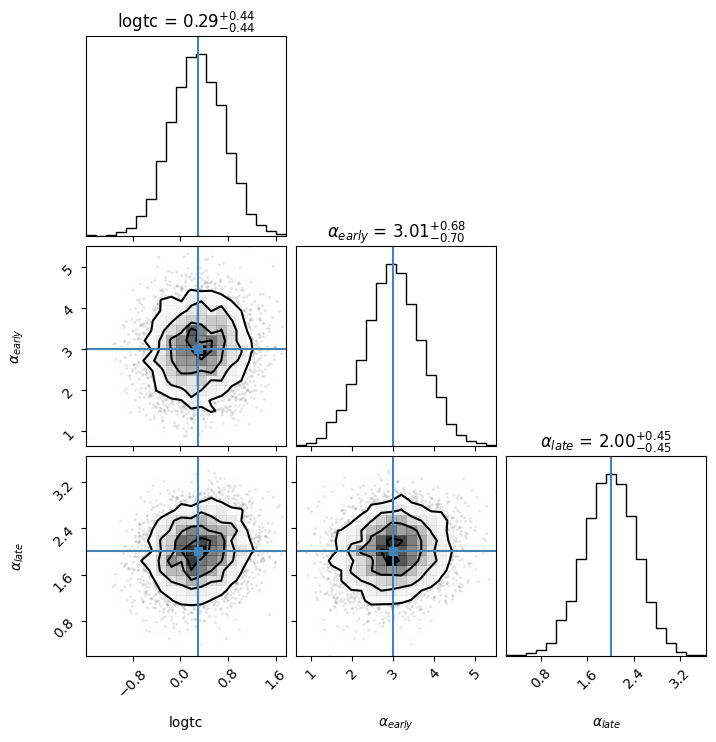

In [7]:
def sample_gaussian_cholesky(mu, cov, key, N=5000):
    L = jnp.linalg.cholesky(cov)
    z = jax.random.normal(key, shape=(N, 3))
    return mu + z @ L.T


# Sample
key = jax.random.PRNGKey(42)
samples = sample_gaussian_cholesky(mu_true, cov_true, key)

# Convert to NumPy for plotting
samples_np = np.array(samples)

# Plot corner plot
figure = corner.corner(samples_np, labels=["logtc", "$\u03b1_{early}$", "$\u03b1_{late}$"],
                       truths=mu_true, show_titles=True, title_fmt=".2f")

plt.show()

In [8]:
def diffmahpop_model(psi, tarr):
    samples = sample_gaussian_cholesky(psi["mu"], psi["cov"], key, N=5000)
    logtc_draws = samples[:,0]
    early_draws = samples[:,1]
    late_draws  =  samples[:,2]

    ZZ = jnp.zeros(len(logtc_draws))
    logt0 = jnp.log10(tarr[-1])
    
    #fixed parameters
    logm0_arr = 13. + ZZ
    t_peak_arr = 14.0 + ZZ

    
    mah_params = DEFAULT_MAH_PARAMS._make((logm0_arr, logtc_draws, early_draws, late_draws, t_peak_arr))
    dmhdt, log_mahs = mah_halopop(mah_params, tarr, logt0)

    return log_mahs, jnp.mean(log_mahs, axis=0), jnp.var(log_mahs, axis=0)

In [9]:
def mse(mean_mhalo_true: jnp.ndarray, mean_mhalo_pred: jnp.ndarray,
       var_mhalo_true: jnp.ndarray, var_mhalo_pred: jnp.ndarray) -> float:
    """Mean squared error function."""
    return jnp.mean(jnp.power(mean_mhalo_true - mean_mhalo_pred, 2)) + jnp.mean(jnp.power(var_mhalo_true - var_mhalo_pred, 2))

In [10]:
def mseloss(psi, model, tarr, mean_mhalo_true, var_mhalo_true):
    _, mean_mhalo_pred, var_mhalo_pred = model(psi, tarr)
    return mse(mean_mhalo_true, mean_mhalo_pred, var_mhalo_true, var_mhalo_pred)

In [11]:
dmseloss = grad(mseloss)

In [24]:
def model_optimization_loop(psi, model, loss, dloss, tarr, mean_mhalo_true, var_mhalo_true,
                            n_steps=20000, step_size=0.001):
    
    losses = []

    for i in tqdm(range(n_steps)):
        
        grads = dloss(dict(mu=psi["mu"], cov=psi["cov"]),
                      model, tarr, mean_mhalo_true, var_mhalo_true)
        
        psi["mu"]   = psi["mu"]   -  step_size*grads["mu"]
        psi["cov"]  = psi["cov"]  -  step_size*grads["cov"]

        losses.append(loss(dict(mu=psi["mu"], cov=psi["cov"]), 
                           model, tarr, mean_mhalo_true, var_mhalo_true))

    return losses, psi

#### Fiducial model

In [25]:
tarr = jnp.linspace(0.5, 13.8, 100)
log_mahs_true, mean_mhalo_true, var_mhalo_true = diffmahpop_model(dict(mu=mu_true, cov=cov_true), tarr)


#### Random initial guess

In [26]:
cov_true

Array([[0.2 , 0.  , 0.  ],
       [0.04, 0.5 , 0.  ],
       [0.06, 0.08, 0.2 ]], dtype=float32)

In [27]:
logtc_mean_rand = np.random.uniform(jnp.log10(1),jnp.log10(3))
logtc_var_rand = np.random.uniform(0.1,0.3)

early_mean_rand = np.random.uniform(0.1,10)
early_var_rand = np.random.uniform(0.2,0.7)

late_mean_rand = np.random.uniform(0.1,5)
late_var_rand = np.random.uniform(0.1,0.3)

off_diag_rand = [np.random.uniform(0.01,0.09), np.random.uniform(0.01,0.09), np.random.uniform(0.01,0.09)]
mu_rand = jnp.array([logtc_mean_rand, early_mean_rand, late_mean_rand])
cov_rand = jnp.array([[logtc_var_rand,  0,    0],
                      [off_diag_rand[0], early_var_rand,  0],
                      [off_diag_rand[1], off_diag_rand[2], late_var_rand]])

log_mahs_guess, mean_mhalo_guess, var_mhalo_guess = diffmahpop_model(dict(mu=mu_rand, cov=cov_rand), tarr)


In [28]:
cov_rand

Array([[0.10103001, 0.        , 0.        ],
       [0.06351439, 0.4369827 , 0.        ],
       [0.05809624, 0.08905112, 0.29040742]], dtype=float32)

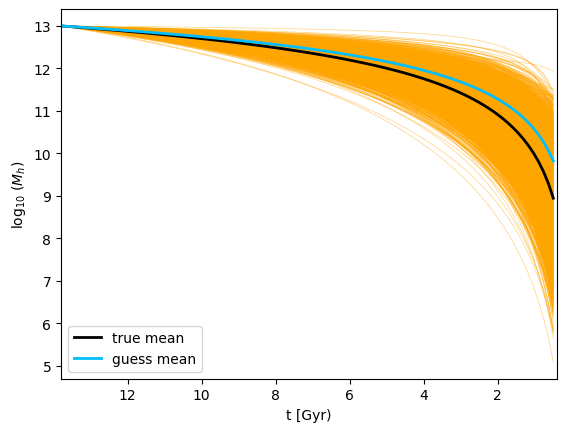

In [29]:
fig, ax = plt.subplots(1, 1)
# __=ax.semilogy()

i=0
for mah in log_mahs_true:
    __=ax.plot(tarr, mah, color='orange', alpha=0.5, lw=0.5)
    i+=1
__=ax.plot(tarr, mean_mhalo_true, c='k', lw=2, label='true mean')
__=ax.plot(tarr, mean_mhalo_guess, c='deepskyblue', lw=2, label='guess mean')



__=ax.set_xlabel('t [Gyr)')
__=ax.set_xlim(0.4,13.8)
__=ax.invert_xaxis()
ax.set_ylabel('log$_{10}$ ($M_{h}$)')
plt.legend()
plt.show()

In [30]:
losses, psi = model_optimization_loop(dict(mu=mu_rand, cov=cov_rand),
                                      diffmahpop_model, mseloss, dmseloss, tarr, 
                                      mean_mhalo_true, var_mhalo_true)

  0%|          | 0/20000 [00:00<?, ?it/s]

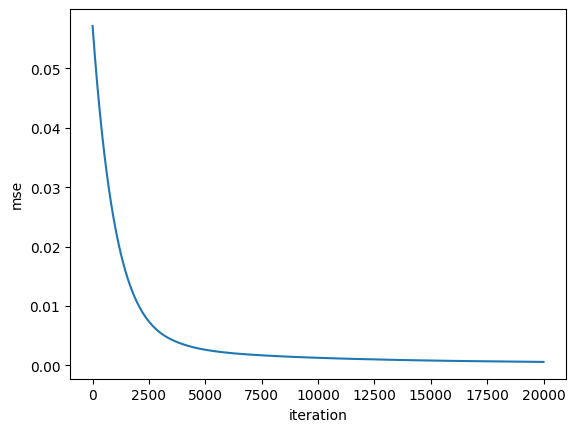

In [31]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('mse')
plt.show()

#### Fitted model

In [32]:
log_mahs_fit, mean_mhalo_fit, var_mhalo_fit = diffmahpop_model(dict(mu=psi["mu"], cov=psi["cov"]), tarr)

In [33]:
mean_mhalo_fit

Array([ 9.100258 ,  9.398515 ,  9.641853 ,  9.847688 , 10.026135 ,
       10.183608 , 10.324437 , 10.451697 , 10.567661 , 10.674054 ,
       10.772228 , 10.86326  , 10.948027 , 11.027247 , 11.101528 ,
       11.17138  , 11.237242 , 11.299484 , 11.358436 , 11.414384 ,
       11.467577 , 11.518239 , 11.5665655, 11.612733 , 11.656901 ,
       11.69921  , 11.739787 , 11.778752 , 11.816211 , 11.852254 ,
       11.886974 , 11.92045  , 11.952757 , 11.983962 , 12.01413  ,
       12.043314 , 12.071571 , 12.098949 , 12.125497 , 12.151255 ,
       12.17626  , 12.200555 , 12.224172 , 12.247142 , 12.269497 ,
       12.291264 , 12.312471 , 12.333142 , 12.353302 , 12.372972 ,
       12.39217  , 12.410921 , 12.42924  , 12.447145 , 12.464652 ,
       12.481777 , 12.498536 , 12.514941 , 12.531006 , 12.546744 ,
       12.562168 , 12.577288 , 12.5921135, 12.606658 , 12.62093  ,
       12.634934 , 12.648686 , 12.662191 , 12.675458 , 12.688495 ,
       12.701307 , 12.713904 , 12.726292 , 12.738476 , 12.7504

In [34]:
var_mhalo_fit

Array([8.77972245e-01, 7.39371896e-01, 6.35808349e-01, 5.55000007e-01,
       4.89987254e-01, 4.36468124e-01, 3.91612887e-01, 3.53472471e-01,
       3.20654333e-01, 2.92133272e-01, 2.67136544e-01, 2.45069087e-01,
       2.25464553e-01, 2.07951605e-01, 1.92230791e-01, 1.78057268e-01,
       1.65229112e-01, 1.53577879e-01, 1.42962083e-01, 1.33261651e-01,
       1.24374174e-01, 1.16211742e-01, 1.08698361e-01, 1.01767972e-01,
       9.53629538e-02, 8.94327983e-02, 8.39329958e-02, 7.88241997e-02,
       7.40715712e-02, 6.96440190e-02, 6.55138269e-02, 6.16562180e-02,
       5.80489449e-02, 5.46719171e-02, 5.15070930e-02, 4.85381410e-02,
       4.57502790e-02, 4.31300960e-02, 4.06653583e-02, 3.83449718e-02,
       3.61588039e-02, 3.40975858e-02, 3.21528427e-02, 3.03168185e-02,
       2.85823755e-02, 2.69429591e-02, 2.53925677e-02, 2.39256304e-02,
       2.25370303e-02, 2.12220550e-02, 1.99763253e-02, 1.87957846e-02,
       1.76766999e-02, 1.66155938e-02, 1.56092579e-02, 1.46546634e-02,
      

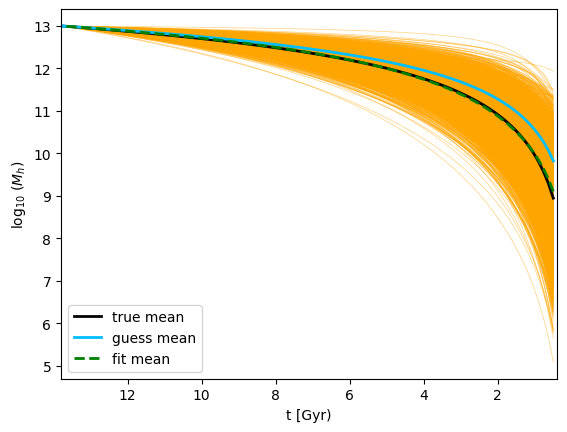

In [35]:
fig, ax = plt.subplots(1, 1)
# __=ax.semilogy()

i=0
for mah in log_mahs_true:
    __=ax.plot(tarr, mah, color='orange', alpha=0.5, lw=0.5)
    i+=1
__=ax.plot(tarr, mean_mhalo_true, c='k', lw=2, label='true mean')
__=ax.plot(tarr, mean_mhalo_guess, c='deepskyblue', lw=2, label='guess mean')
__=ax.plot(tarr, mean_mhalo_fit, c='g', ls ='--', lw=2, label='fit mean')




__=ax.set_xlabel('t [Gyr)')
__=ax.set_xlim(0.4,13.8)
__=ax.invert_xaxis()
ax.set_ylabel('log$_{10}$ ($M_{h}$)')
plt.legend()
plt.show()